![alt text](images/CV/intro.png)

## Table of Contents
- Intro to PyTorch
    - Hello World
    - Auto Grad
    - Linear Regression
    - Gradient Descent
    - Logistic Regression
    - Data loaders for SGD
    - Two layer neural network
- CNNs

# Intro to PyTorch

In [2]:
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd;
import numpy as np;
import random;
import math;


Apart from the general Python imports for math, random, Pandas, and and Numpy, we will import the Torch utilities. These include the torch, torch.nn, and torch.utils for the Dataset loaders.

**PyTorch consists of 4 main packages:**

- torch: a general purpose array library similar to Numpy that can do computations on GPU
- torch.autograd: a package for automatically obtaining gradients
- torch.nn: a neural net library with common layers and cost functions
- torch.optim: an optimization package with common optimization algorithms like SGD, Adam, etc

### Hello World in PyTorch - Tensors

Instead of a traditional "Hello World" print statement, we can validate PyTorch is functioning properly by creating and outputing a Tensor.

In [3]:
# Create random tensor
N = 5
x = torch.randn(N, 10).type(torch.FloatTensor)

PyTorch tensors are like Numpy tensors but they can utilize GPUs to accelerate numerical computations.

In [4]:
# reshaping of tensors using .view()
x.view(1,-1) #-1 makes torch infer the second dim

tensor([[-1.6012, -0.2236, -0.3630,  0.7613, -1.7640,  0.5050, -0.0608,  0.6809,
         -1.1296,  0.2536,  1.0859, -0.7458, -1.8010, -1.0372,  1.0498, -0.3219,
         -1.4990,  1.2559, -0.6107, -0.4920, -1.2939, -0.6129, -0.6312,  0.7270,
          0.8831,  0.1291,  1.0351,  0.8147,  0.0784,  0.2739,  0.0203,  0.4925,
         -1.7857,  0.7554,  0.7916,  1.0404,  1.6004, -1.6318,  0.1011,  1.2093,
          0.1046,  0.6645,  0.0251, -0.4991, -0.9783, -0.7277,  0.5914,  0.9022,
          0.6752, -0.3744]])

## Pytorch Autograd

The autograd package in PyTorch automates the computation of backward passes in neural networks. That is, the gradient of the error with respect to all parameters.

In order for this to happen we need to wrap up our data and paramerers with the aurograd.Variable() function. Each variable has a .grad property which is it’s gradient with respect to our Error function. Each variable also has a .data property which is it the actual value of the tensor.

In [5]:
x = torch.tensor([1., 2., 3., 4., 5., 6.], requires_grad=True)

In [6]:
x.grad

In [7]:
l = (2*x+1).sum()
l

tensor(48., grad_fn=<SumBackward0>)

In [8]:
l.backward()

In [9]:
x.grad

tensor([2., 2., 2., 2., 2., 2.])

## torch.nn module

A neural net library with common layers and cost functions

In [14]:
# linear transformation of a Nx5 matrix into a Nx3 matrix, where N can be anything 
# (number of observations)
D = 5 # number of input featutes
M = 3 # neurons in the first hidden layer
linear_map = nn.Linear(D, M)

In [15]:
# parameters are initialized randomly# parame 
[p for p in linear_map.parameters()]

[Parameter containing:
 tensor([[ 0.1235, -0.0306, -0.0028, -0.2900,  0.4355],
         [ 0.0853,  0.3501, -0.4328,  0.0115,  0.0679],
         [-0.3683, -0.2714, -0.1178,  0.0258, -0.2710]], requires_grad=True),
 Parameter containing:
 tensor([ 0.3280,  0.3532, -0.2429], requires_grad=True)]

## Linear Regression

The goal of linear regression is to fit a line to a set of points. Considered the simplest neural network possible with 1 input and 1 output.

![Linear ](images/CV/linear.png)

In regular neural networks, we typically have multiple layers, non-linear activation functions, and a bias for each node. In this section, we only have one layer with one weight parameter w, no activation function on the output, and no bias.

In [16]:
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, y

x, y = gen_fake_data(50, 3., 8.)

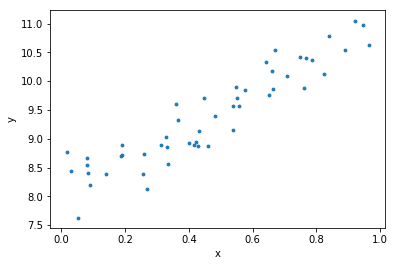

In [17]:
import matplotlib.pyplot as plt
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y");

You want to find parameters (weights) $a$ and $b$ such that you minimize the error between the points and the line $a\cdot x + b$. Note that here $a$ and $b$ are unknown. For a regression problem the most common error function or loss function is the mean squared error.

In [18]:
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()

Suppose we believe $a = 10$ and $b = 5$ then we can compute y_hat which is our prediction and then compute our error.

In [19]:
y_hat = lin(10,5,x)
mse(y_hat, y)

3.6928463551871973

In [20]:
def mse_loss(a, b, x, y): return mse(lin(a,b,x), y)

In [21]:
mse_loss(10, 5, x, y)

3.6928463551871973

So far we have specified the model (linear regression) and the evaluation criteria (or loss function). Now we need to handle optimization; that is, how do we find the best values for $a$ and $b$? How do we find the best fitting linear regression.

## Gradient Descent with Pytorch

For a fixed dataset $x$ and $y$ mse_loss(a,b) is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

Gradient descent is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

**Gradient** means the **rate** of inclination or declination of a slope.

**Descent** means the instance of **descending**.

![Gradient Descent](images/CV/gd.gif)

The algorithm is iterative means that we need to get the results multiple times to get the most optimal result. The iterative quality of the gradient descent helps a under-fitted graph to make the graph fit optimally to the data.

Here is gradient descent implemented in PyTorch.

In [22]:
# generate some more data
x, y = gen_fake_data(10000, 3., 8.)
x.shape, y.shape

((10000,), (10000,))

In [23]:
# Wrap x and y as tensor 
x = torch.tensor(x)
y = torch.tensor(y)

In [24]:
# Create random Tensors for weights, and wrap them in Variables.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Variables during the backward pass.
a, b = np.random.randn(1), np.random.randn(1)
a = torch.tensor(a, requires_grad=True)
b = torch.tensor(b, requires_grad=True)
a,b

(tensor([-0.7251], dtype=torch.float64, requires_grad=True),
 tensor([0.5245], dtype=torch.float64, requires_grad=True))

In [25]:
learning_rate = 1e-3
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    loss = mse_loss(a,b,x,y)
    if t % 1000 == 0: print(loss.item())
    
    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    
    # Zero the gradients
    a.grad.data.zero_()
    b.grad.data.zero_()

88.25637301110963
0.6506569843163494
0.09588971053730401
0.09195281295976947
0.09159942393335443
0.09134468611177093
0.09114897844093503
0.0909985404151914
0.09088290008050769
0.09079400840946471


In [26]:
print(a,b)

tensor([3.0542], dtype=torch.float64, requires_grad=True) tensor([7.9731], dtype=torch.float64, requires_grad=True)


## Logistic Regression (Classification)

While the previous section described a very simple one-input-one-output linear regression model, this section will describe a 2-class classification neural network with two input dimensions. This model is known in statistics as the logistic regression model. This network can be represented graphically as:

![ANN](images/CV/ANN.png)

In [27]:
# generating fake data
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_logistic_fake_data(n, a, b):
    x = np.random.uniform(-20,20, (n, 2))
    x2_hat = lin(a,b, x[:,0])
    y = x[:,1] > x2_hat
    return x, y.astype(int)

x, y = gen_logistic_fake_data(100, 1., 0.5)

In [28]:
y

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1])

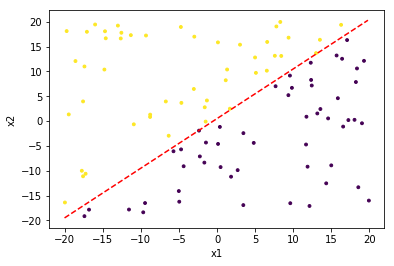

In [29]:
t = np.arange(-20, 20, 0.2)
import matplotlib.pyplot as plt
plt.scatter(x[:,0],x[:,1],c=y, s=8);
plt.xlabel("x1"); plt.ylabel("x2");
plt.plot(t, t + 0.5, 'r--')

In [30]:
#Define tensors for x,y variables
x = torch.tensor(x).float()
y = torch.tensor(y).float()

Define model as linear within a sequential container - Modules will be added to it in the order they are passed in the constructor. Alternatively, an ordered dict of modules can also be passed in.

In [34]:

model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
)
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

In [35]:
model(x).shape

torch.Size([10000, 1])

In [36]:
x, y = gen_logistic_fake_data(10000, 1., 0.5)
x = torch.tensor(x).float()
y = torch.tensor(y).float()

In [37]:
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Adam: A Method for Stochastic Optimization.

The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

For more info: [Gentle Introduction to the Adam Optimization Algorithm for Deep Learning](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

In [38]:
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    y_hat = model(x)
    loss = F.binary_cross_entropy(torch.sigmoid(y_hat), y.unsqueeze(1))
    if t % 1000 == 0: print(loss.item())
       
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables
    optimizer.zero_grad()
    loss.backward()
    
    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

7.435468673706055
0.01940820924937725
0.01344561018049717
0.010425669141113758
0.008448543027043343
0.006983956787735224
0.005821514409035444
0.004862133879214525
0.0040552350692451
0.0033735213801264763


In [39]:
print([p/136 for p in model.parameters()])

[tensor([[-0.1219,  0.1218]], grad_fn=<DivBackward0>), tensor([-0.0597], grad_fn=<DivBackward0>)]


## Stochastic Gradient Descent

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seen as an approximation of gradient descent (GD). In GD you have to run through all the samples in your training set to do a single iteration. In SGD you use only one or a subset of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a batch or minibatch.

In [40]:
#Define Model
model2 = torch.nn.Sequential(
    torch.nn.Linear(1, 1),
)

In [41]:
#import data loaders
from torch.utils.data import Dataset, DataLoader

In [42]:
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x.astype(np.float32), y.astype(np.float32)

# create a dataset
class RegressionDataset(Dataset):
    def __init__(self, a=3, b=8, n=10000):
        x, y = gen_fake_data(n, a, b)
        x = torch.from_numpy(x).unsqueeze(1)
        y = torch.from_numpy(y)
        self.x, self.y = x, y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
fake_dataset = RegressionDataset()

**Next we are going to create a data loader. The data loader provides the following features:**

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

In [43]:
dataloader = DataLoader(fake_dataset, batch_size=1000, shuffle=True)
x, y = next(iter(dataloader))

In [44]:
y.type(torch.FloatTensor)

tensor([11.1351,  9.3789, 10.1327,  8.9609, 10.4063,  9.3867, 11.1780, 10.5045,
         9.0582,  8.2513, 10.2795,  8.5969,  9.3117,  8.5690,  8.9277,  9.5898,
        11.0354,  8.8075, 10.4615,  9.9987, 10.2279,  9.1246, 11.1517, 10.5073,
         9.8906,  8.0565,  9.0783,  8.9054,  8.3081, 10.0470,  9.4462, 10.5471,
         9.7046,  8.2618,  9.1208,  8.2173,  7.8926, 10.4708, 10.6499, 11.1063,
         9.9732,  9.7096,  9.5349,  9.2575,  9.6069, 11.3219,  8.0231,  9.5332,
         9.7668,  9.2371, 10.0639, 10.7630, 10.3171, 10.6521,  9.5344, 11.1852,
         9.5424, 11.4148,  8.7823, 10.9610,  9.6585, 10.8405,  8.9384,  8.1481,
        11.0902, 10.4644,  9.3164,  8.5732,  9.4854,  9.8424, 10.3562,  8.6314,
         9.6656, 10.5004,  8.4500,  7.7864,  8.9358,  8.7574,  9.6404,  9.7594,
        11.2443, 10.7379,  8.2379, 11.2000,  9.7365,  9.6627,  8.3959, 10.1063,
         7.9802, 11.0544, 10.4737, 10.4990,  9.4486,  9.5551,  9.4894,  8.6608,
         8.9736,  8.9553,  9.7563,  8.67

In [45]:
learning_rate = 0.1
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [46]:
from torch.autograd import Variable

for t in range(1000):
    for i, (x, y) in enumerate(dataloader): 
        x = Variable(x, requires_grad=False)
        y = Variable(y, requires_grad=False)
        y = y.type(torch.FloatTensor)
        
        y_hat = model2(x)
        loss = F.mse_loss(y_hat, y.unsqueeze(1))
    
        optimizer.zero_grad()
        loss.backward()
    
        optimizer.step()
    if t % 100 == 0: print(loss.item())

63.218387603759766
0.0825868472456932
0.086882583796978
0.0944126695394516
0.08631233870983124
0.08330246806144714
0.09248621761798859
0.08875683695077896
0.09336121380329132
0.09259042143821716


In [47]:
print([p for p in model2.parameters()])

[Parameter containing:
tensor([[2.9975]], requires_grad=True), Parameter containing:
tensor([7.9986], requires_grad=True)]


## Two Layer Neural Network

While the previous section described very simple single layer regression and classification models, this section will include a 2-class classification neural network with 1 input dimension, and a non-linear hidden layer with 1 neuron. This network can be represented graphically as:

![ANN](images/CV/nn.png)

In [48]:
# generating fake data
# Here we generate some fake data
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def gen_nn_fake_data(n):
    x = np.random.uniform(0,10, (n, 2))
    x1 = x[:,0]
    x2 = x[:,1]
    score1 = sigmoid(-x1 - 8* x2 + 50)
    score2 = sigmoid(-7*x1 - 2* x2 + 50)
    score3 = 2* score1 + 3*score2 - 0.1
    y = score3 < 0
    return x, y.astype(int)

x, y = gen_nn_fake_data(500)

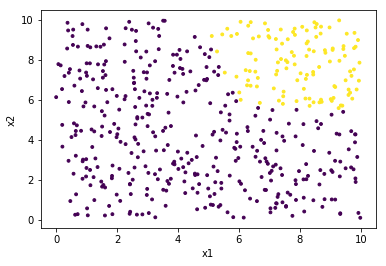

In [49]:
import matplotlib.pyplot as plt
plt.scatter(x[:,0],x[:,1],c=y, s=8);
plt.xlabel("x1"); plt.ylabel("x2");

In [50]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 2),
    torch.nn.Sigmoid(),
    torch.nn.Linear(2, 1)
)
model

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [51]:
x, y = gen_nn_fake_data(10000)
x = torch.tensor(x).float()
y = torch.tensor(y).float()

In [52]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [54]:
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    y_hat = model(x)
    loss = F.binary_cross_entropy(torch.sigmoid(y_hat), y.unsqueeze(1))
    if t % 1000 == 0: print(loss.item())
       
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables
    optimizer.zero_grad()
    loss.backward()
    
    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0.004453662782907486
0.003682316280901432
0.00309032597579062
0.0026216863188892603
0.0022431733086705208
0.0019339717691764235
0.0016784698236733675
0.0014770118286833167
0.0012972736731171608
0.001156147918663919


In [55]:
print([p for p in model.parameters()])

[Parameter containing:
tensor([[-8.0310, -2.2697],
        [-0.9619, -7.5730]], requires_grad=True), Parameter containing:
tensor([60.4882, 49.6399], requires_grad=True), Parameter containing:
tensor([[-63.3176, -66.4983]], requires_grad=True), Parameter containing:
tensor([23.6304], requires_grad=True)]


In [56]:
np.array([72.7843, -134.4691, -45.7142])

array([  72.7843, -134.4691,  -45.7142])

# Convolutional Neural Networks

In [65]:
# library
# standard library
import os
import torch.utils.data as Data
import torchvision

In [61]:
 torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False

# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True


In [62]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

Processing...
Done!


torch.Size([60000, 28, 28])
torch.Size([60000])


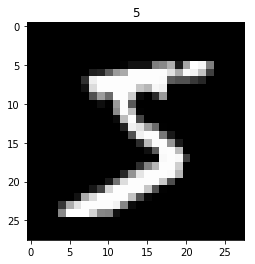

In [63]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [66]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


In [67]:
# pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]


In [68]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [69]:
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [70]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [71]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)


Epoch:  0 | train loss: 2.3105 | test accuracy: 0.06


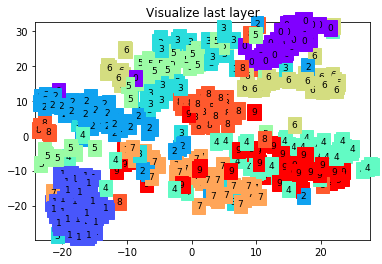

Epoch:  0 | train loss: 0.6184 | test accuracy: 0.83


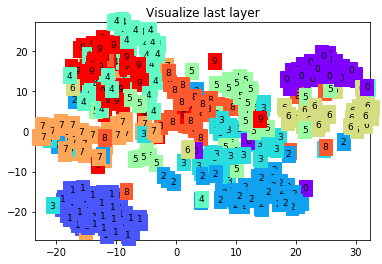

Epoch:  0 | train loss: 0.1270 | test accuracy: 0.87


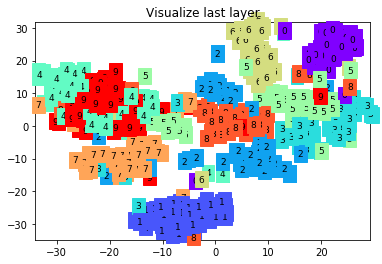

Epoch:  0 | train loss: 0.2368 | test accuracy: 0.91


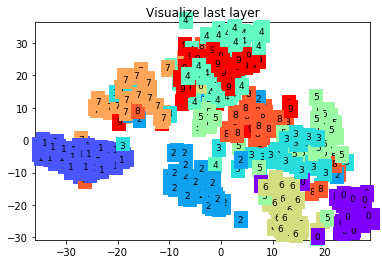

Epoch:  0 | train loss: 0.4052 | test accuracy: 0.93


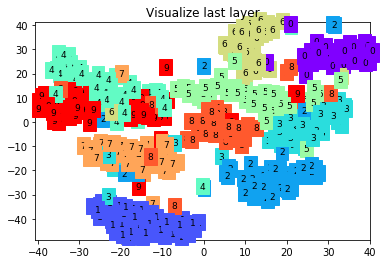

Epoch:  0 | train loss: 0.0843 | test accuracy: 0.94


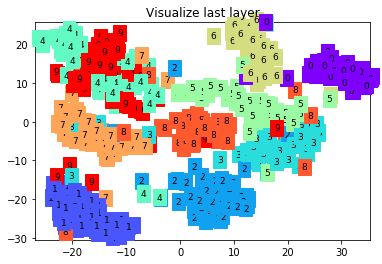

Epoch:  0 | train loss: 0.1942 | test accuracy: 0.95


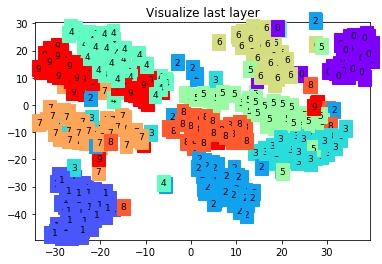

Epoch:  0 | train loss: 0.1097 | test accuracy: 0.95


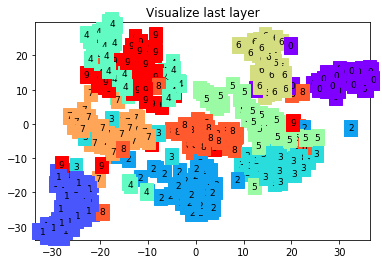

Epoch:  0 | train loss: 0.1249 | test accuracy: 0.96


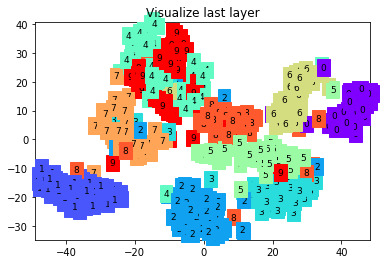

Epoch:  0 | train loss: 0.0683 | test accuracy: 0.96


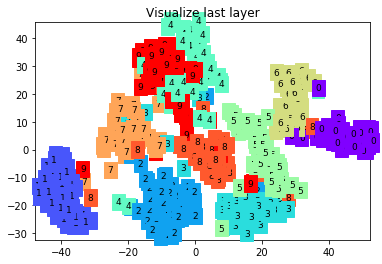

Epoch:  0 | train loss: 0.2232 | test accuracy: 0.96


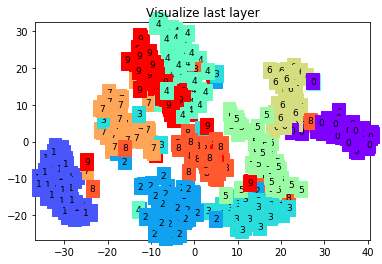

Epoch:  0 | train loss: 0.2124 | test accuracy: 0.96


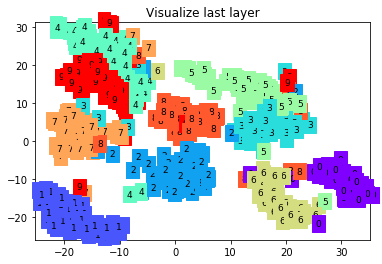

Epoch:  0 | train loss: 0.0235 | test accuracy: 0.97


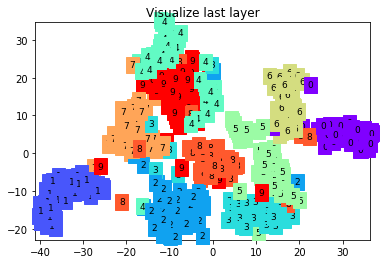

Epoch:  0 | train loss: 0.0892 | test accuracy: 0.97


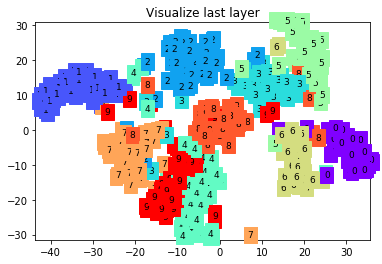

Epoch:  0 | train loss: 0.2128 | test accuracy: 0.97


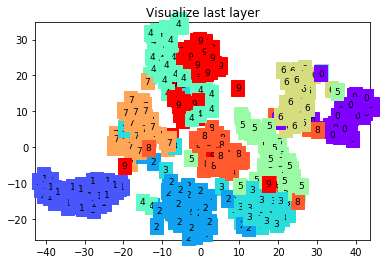

Epoch:  0 | train loss: 0.1034 | test accuracy: 0.97


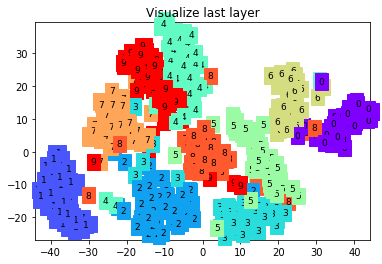

Epoch:  0 | train loss: 0.0434 | test accuracy: 0.97


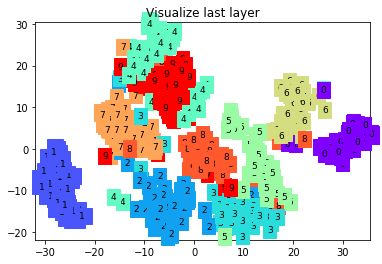

Epoch:  0 | train loss: 0.0948 | test accuracy: 0.98


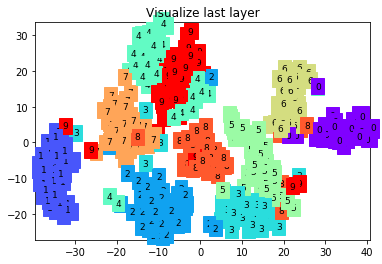

Epoch:  0 | train loss: 0.0540 | test accuracy: 0.98


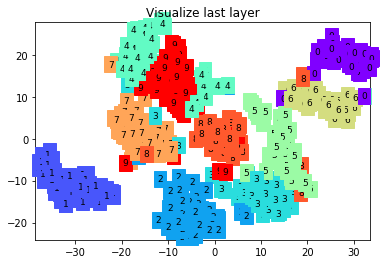

Epoch:  0 | train loss: 0.0963 | test accuracy: 0.98


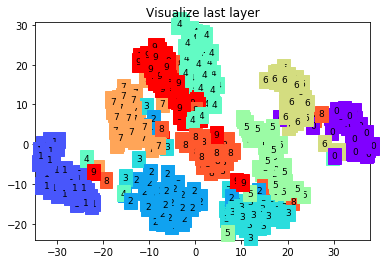

Epoch:  0 | train loss: 0.0326 | test accuracy: 0.98


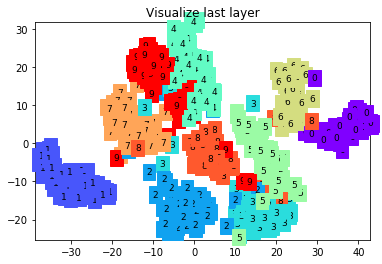

Epoch:  0 | train loss: 0.0231 | test accuracy: 0.98


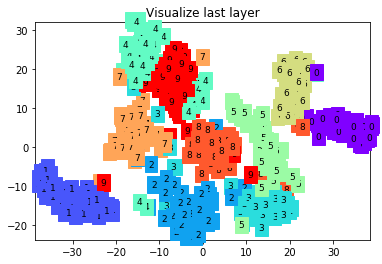

Epoch:  0 | train loss: 0.0254 | test accuracy: 0.98


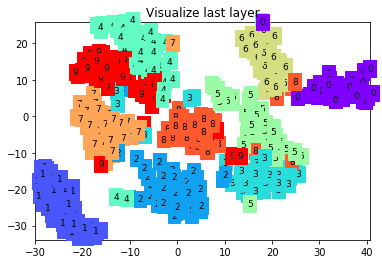

Epoch:  0 | train loss: 0.1200 | test accuracy: 0.98


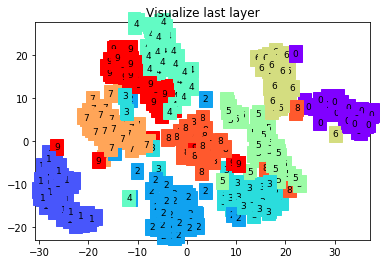

In [72]:
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

In [73]:
# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number



# References

- http://pytorch.org/tutorials/beginner/pytorch_with_examples.html
- https://hsaghir.github.io/data_science/pytorch_starter/
- http://a.sjtume.cn/2017/PyTorch-CNN/
